In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import glob
import os
import cv2
# Be able to import from src folder
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

import misc.notebookHelpers

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams['figure.figsize'] = (10, 10)

/Users/torjushaukom/Documents/Studier/Masteroppgave/Strain_estimation


In [8]:
data_path = '../data/raw/Ultrasound/'

In [ ]:
folder = '../data/raw/Ultrasound/p1/'
paths_for_p1 = glob.glob(folder + '/*.h5')
imgs = []
for path in paths_for_p1:
    f = h5py.File(path)
    img = f['tissue/data'][:, :, 15]
    img = np.transpose(img)
    imgs.append(img)
    f.close()

In [ ]:
len(imgs)

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
for i in range(4):
    for j in range(3):
        ax[i, j].imshow(imgs[4*(i - 1) + j])
plt.tight_layout()

## First impression
Open a sample for inspection

In [9]:
data_file_paths = glob.glob(data_path + '*/*.h5')
file_idx = np.random.randint(0, len(data_file_paths))
data_file = h5py.File(data_file_paths[file_idx])

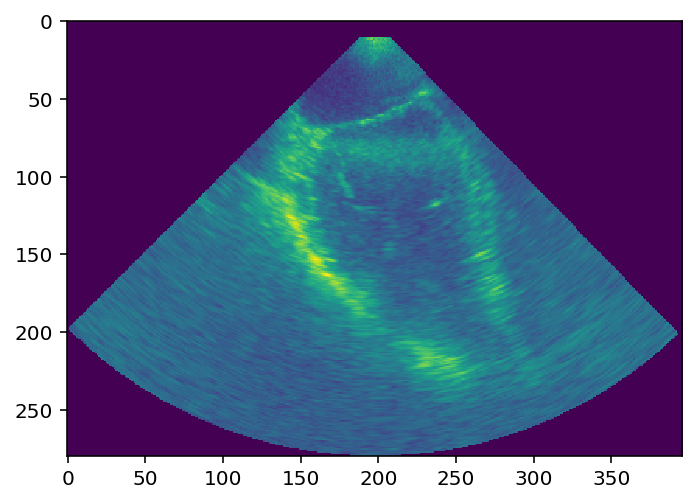

In [10]:
test = data_file['tissue/data']
test = np.transpose(test, [2, 1, 0])
plt.imshow(test[5, :, :])

Show a b-mode sample

In [11]:
video, fps = misc.notebookHelpers.video_and_fps_from_h5py(data_file)

In [13]:
misc.notebookHelpers.ultraSoundAnimation(video, fps=fps)

Show TVI from the same sample

In [14]:
tvi_video, tvi_fps = misc.notebookHelpers.video_and_fps_from_h5py(data_file, video_type='tvi')

In [16]:
misc.notebookHelpers.ultraSoundAnimation(np.abs(tvi_video), fps=tvi_fps / 4)

### Try to segment based on velocity thresholding
As the frame rate of TVI and b-mode are different, need to pick the closest TVI frame for each b-mode frame

In [18]:
print(video.shape, tvi_video.shape)

(57, 280, 396) (224, 280, 396)


In [19]:
video_times = data_file['tissue/times']
tvi_times = data_file['TVI/times']

In [20]:
downsample_idc = []
for time in video_times:
    idx = np.argmin(np.abs(tvi_times - time))
    downsample_idc.append(idx)
downsampled_tvi = tvi_video[downsample_idc, :, :]

In [21]:
downsampled_tvi = (np.abs(downsampled_tvi) / np.max(np.abs(downsampled_tvi)) * 255).astype('uint8')

In [24]:
misc.notebookHelpers.ultraSoundAnimation(downsampled_tvi, fps=fps/4)

Try smoothing with median blur

In [25]:
import cv2

In [28]:
smoothed_ds_tvi = np.empty_like(downsampled_tvi)
for i in range(downsampled_tvi.shape[0]):
    smoothed_ds_tvi[i, :, :] = cv2.medianBlur(downsampled_tvi[i, :, :], 3)
misc.notebookHelpers.ultraSoundAnimation(smoothed_ds_tvi, fps=fps / 4)

Try smoothing in time in stead

In [33]:
tvi_exp_filtered = downsampled_tvi
alpha = .55
for i in range(1, tvi_exp_filtered.shape[0]):
    tvi_exp_filtered[i, :, :] = alpha * tvi_exp_filtered[i, :, :] + (1 - alpha) * tvi_exp_filtered[i - 1, :, :]
misc.notebookHelpers.ultraSoundAnimation(tvi_exp_filtered, fps=fps / 4)

Try smoothing first in time, then with median blur

In [37]:
smoothed_ds_tvi = np.empty_like(tvi_exp_filtered)
for i in range(downsampled_tvi.shape[0]):
    smoothed_ds_tvi[i, :, :] = cv2.medianBlur(tvi_exp_filtered[i, :, :], 5)
misc.notebookHelpers.ultraSoundAnimation(smoothed_ds_tvi, fps=fps / 4, with_colorbar=True)

This looks promising, try to make a mask based on thresholding

In [47]:
mask = np.zeros_like(smoothed_ds_tvi)
mask[smoothed_ds_tvi > 60] = 255
misc.notebookHelpers.ultraSoundAnimation(mask, fps=fps / 4)

In [48]:
segmented = video
segmented[mask == 255] = 0
misc.notebookHelpers.ultraSoundAnimation(segmented, fps=fps / 8)

Try some morphology on this mask

In [40]:
morphed_mask = np.empty_like(mask)
for i in range(morphed_mask.shape[0]):
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(mask[i, :, :],cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
    morphed_mask[i, :, :] = sure_bg

misc.notebookHelpers.ultraSoundAnimation(morphed_mask, fps=fps / 4)

In [42]:
segmented = video
segmented[morphed_mask == 255] = 0
misc.notebookHelpers.ultraSoundAnimation(segmented, fps=fps / 8)

Try to make one 

In [ ]:
mask = np.zeros(shape=downsampled_tvi.shape)
for i in range(mask_percent.shape[0]):
    tvi_frame = downsampled_tvi[i, :, :]
    ret, thresh = cv2.threshold(tvi_frame, 75, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
    mask[i, :, :] = sure_bg

misc.notebookHelpers.ultraSoundAnimation(mask, fps)

In [ ]:
segmented = video
segmented *= mask

In [ ]:
misc.notebookHelpers.ultraSoundAnimation(segmented, fps / 20)

To reduce noise, average TVI-frames between b-mode frames

In [ ]:
average_idc = []
for i in range(0, len(downsample_idc) - 1):
    average_idc.append([])
    j = 0

    while tvi_times[downsample_idc[i]+j] != tvi_times[downsample_idc[i+1]]:
        average_idc[i].append(downsample_idc[i] + j)
        j += 1
average_idc.append([downsample_idc[-1]])

In [ ]:
downsampled_filtered_tvi = np.zeros(shape=(video.shape[0], ) + tvi_video.shape[1:])
for i in range(downsampled_filtered_tvi.shape[0]):
    idc = average_idc[i]
    downsampled_filtered_tvi[i] = np.mean(tvi_video[idc, :, :], axis=0)
misc.notebookHelpers.ultraSoundAnimation(downsampled_filtered_tvi, fps / 8)

In [ ]:
mask = np.abs(downsampled_filtered_tvi) < 0.025
misc.notebookHelpers.ultraSoundAnimation(mask.astype('int64'), fps / 4)

In [ ]:
segmented = video[:, :, :]
segmented *= mask
notebook_helpers.ultraSoundAnimation(segmented, fps / 8)